# [4주차 심화과제] HuggingFace로 두 문장의 논리적 모순 분류하기


이번 과제는 자연어 task 중 하나인 MNLI를 해결하는 모델을 HuggingFace로 학습하는 것입니다. MNLI를 요약하면 다음과 같습니다.

- **입력**: premise에 해당하는 문장과 hypothesis에 해당하는 문장 두 개가 입력으로 들어옵니다.
- **출력:** 분류 문제로, 두 문장이 들어왔을 때 다음 세 가지를 예측하시면 됩니다.
  - **Entailment:** 두 문장에 논리적 모순이 없습니다.
  - **Neutral:** 두 문장은 논리적으로 관련이 없습니다.
  - **Contradiction:** 두 문장 사이에 논리적 모순이 존재합니다.


In [1]:
import random
import evaluate
import numpy as np

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [2]:
mnli_ds = load_dataset("nyu-mll/glue", "mnli")
mnli_ds

README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

(…)alidation_matched-00000-of-00001.parquet:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

(…)dation_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

test_matched-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

test_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

In [3]:
mnli_ds["train"][0]

{'premise': 'Conceptually cream skimming has two basic dimensions - product and geography.',
 'hypothesis': 'Product and geography are what make cream skimming work. ',
 'label': 1,
 'idx': 0}

In [4]:
from transformers import AutoConfig

# roberta-base 모델의 설정 불러오기
config = AutoConfig.from_pretrained("roberta-base")

# 최대 토큰 길이 확인
print(
    f"Max token length: {config.max_position_embeddings}"
)  # 특수 토큰을 포함하여 514개

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Max token length: 514


In [5]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")


def preprocess_function(data):
    return tokenizer(
        data["premise"],
        data["hypothesis"],
        truncation=True,
        max_length=512,
    )


mnli_tokenized = mnli_ds.map(preprocess_function, batched=True)
mnli_tokenized

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

Map:   0%|          | 0/9796 [00:00<?, ? examples/s]

Map:   0%|          | 0/9847 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 9847
    })
})

In [6]:
mnli_tokenized["train"][0].keys()

dict_keys(['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'attention_mask'])

In [7]:
mnli_tokenized["train"][320]["premise"], mnli_tokenized["train"][320][
    "hypothesis"
], mnli_tokenized["train"][320]["label"]

("that can be a mess we camped at the beach one time and that was sort of miserable you just couldn't everywhere you went there was sand you couldn't even when you're eating it it was in your bed",
 'It is a bad idea to camp and eat on a beach.',
 1)

In [8]:
mnli_tokenized["test_matched"][0]["premise"], mnli_tokenized["test_matched"][0][
    "hypothesis"
], mnli_tokenized["test_matched"][0]["label"]

('Hierbas, ans seco, ans dulce, and frigola are just a few names worth keeping a look-out for.',
 'Hierbas is a name worth looking out for.',
 -1)

In [9]:
mnli_tokenized["test_mismatched"][0]["premise"], mnli_tokenized["test_mismatched"][0][
    "hypothesis"
], mnli_tokenized["test_mismatched"][0]["label"]

('What have you decided, what are you going to do?',
 "So what's your decision?",
 -1)

In [10]:
mnli_split = mnli_tokenized["train"].train_test_split(
    test_size=0.1,
    shuffle=True,
)
mnli_train, mnli_val = mnli_split["train"], mnli_split["test"]
mnli_validation_matched = mnli_tokenized["validation_matched"]
mnli_validation_mismatched = mnli_tokenized["validation_mismatched"]
mnli_test_matched = mnli_tokenized["test_matched"]
mnli_test_mismatched = mnli_tokenized["test_mismatched"]

In [11]:
len(mnli_train), len(mnli_val), len(mnli_test_matched), len(mnli_test_mismatched)

(353431, 39271, 9796, 9847)

In [12]:
config = AutoConfig.from_pretrained(
    "roberta-base",
    num_labels=3,
    classifier_dropout=0.1,  # 분류기 드롭아웃 명시적으로 설정
    architectures=["RobertaForSequenceClassification"],  # 분류기 작업을 위한 모델
    id2label={0: "Entailment", 1: "Neutral", 2: "Contradiction"},  # 레이블 매핑
    label2id={"Entailment": 0, "Neutral": 1, "Contradiction": 2},
)
config

RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": 0.1,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Entailment",
    "1": "Neutral",
    "2": "Contradiction"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Contradiction": 2,
    "Entailment": 0,
    "Neutral": 1
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.45.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base", config=config
)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should pr

In [14]:
def print_model_structure(model, indent=0):
    for name, module in model.named_children():
        print("     " * indent + f"- {name} ({module.__class__.__name__})")
        print_model_structure(module, indent + 1)


# 모델 구조 출력 - 계층 구조를 좀 명확히 확인 해보고 싶었음
print_model_structure(model)

- roberta (RobertaModel)
     - embeddings (RobertaEmbeddings)
          - word_embeddings (Embedding)
          - position_embeddings (Embedding)
          - token_type_embeddings (Embedding)
          - LayerNorm (LayerNorm)
          - dropout (Dropout)
     - encoder (RobertaEncoder)
          - layer (ModuleList)
               - 0 (RobertaLayer)
                    - attention (RobertaAttention)
                         - self (RobertaSdpaSelfAttention)
                              - query (Linear)
                              - key (Linear)
                              - value (Linear)
                              - dropout (Dropout)
                         - output (RobertaSelfOutput)
                              - dense (Linear)
                              - LayerNorm (LayerNorm)
                              - dropout (Dropout)
                    - intermediate (RobertaIntermediate)
                         - dense (Linear)
                         - intermediate_act

In [15]:
# 사전 학습된 부분 (RoBERTa 모델)의 파라미터를 동결
for param in model.roberta.parameters():
    param.requires_grad = False  # RoBERTa의 파라미터를 업데이트하지 않도록 설정

# 분류기 레이어 (classifier)는 그대로 학습
for param in model.classifier.parameters():
    param.requires_grad = True

In [16]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="mnli_matched",  # 모델, log 등을 저장할 directory
    num_train_epochs=10,  # epoch 수
    per_device_train_batch_size=128,  # training data의 batch size
    per_device_eval_batch_size=128,  # validation data의 batch size
    logging_strategy="epoch",  # Epoch가 끝날 때마다 training loss 등을 log하라는 의미
    do_train=True,  # 학습을 진행하겠다는 의미
    do_eval=True,  # 학습 중간에 validation data에 대한 평가를 수행하겠다는 의미
    eval_strategy="epoch",  # 매 epoch가 끝날 때마다 validation data에 대한 평가를 수행한다는 의미
    save_strategy="epoch",  # 매 epoch가 끝날 때마다 모델을 저장하겠다는 의미
    learning_rate=1e-3,  # optimizer에 사용할 learning rate
    load_best_model_at_end=True,  # 학습이 끝난 후, validation data에 대한 성능이 가장 좋은 모델을 채택하겠다는 의미
    metric_for_best_model="eval_accuracy",  # best model을 accuracy 기준으로 선정
    greater_is_better=True,
)

In [17]:
import evaluate

accuracy = evaluate.load("accuracy")


def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [18]:
from transformers import EarlyStoppingCallback
from callback_plot import PlotCallback
from callback_best_model import BestModelCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=mnli_train,
    eval_dataset=mnli_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[
        PlotCallback(),
        BestModelCallback(),
        EarlyStoppingCallback(early_stopping_patience=2),
    ],
)

/root/.cache/pypoetry/virtualenvs/hp-otBRvMad-py3.10/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,1.055200,0.991970,0.532632
2,1.033300,0.987496,0.528558
3,1.029300,0.980039,0.542334
4,1.027700,0.979178,0.536987
5,1.024800,0.974446,0.542130


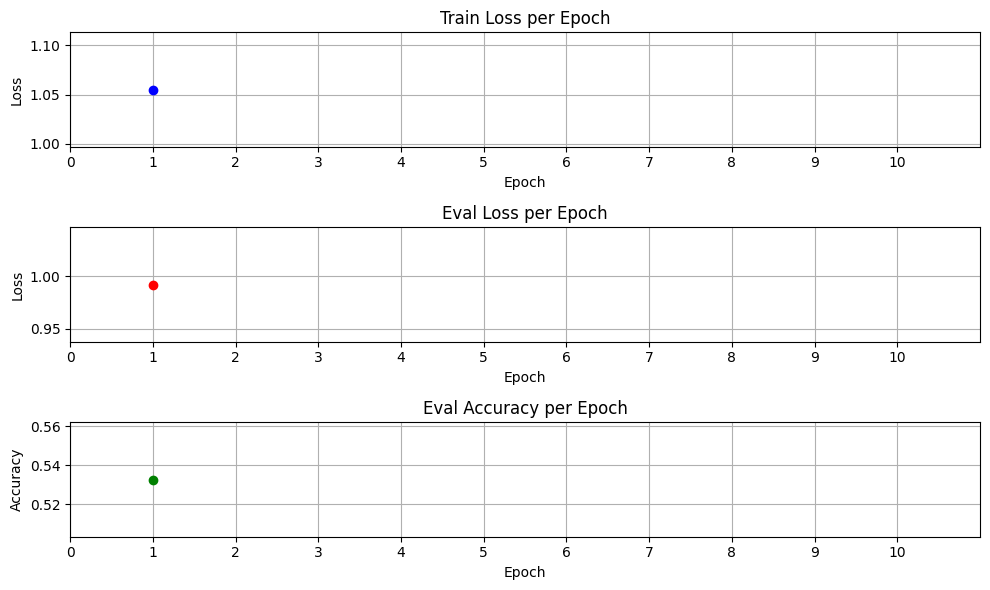

/root/.cache/pypoetry/virtualenvs/hp-otBRvMad-py3.10/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


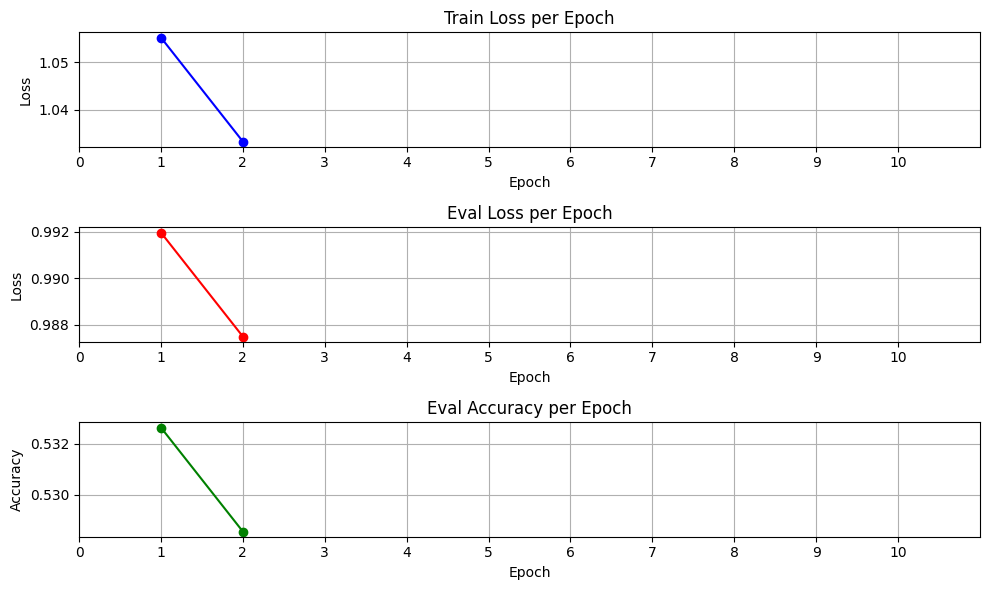

/root/.cache/pypoetry/virtualenvs/hp-otBRvMad-py3.10/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


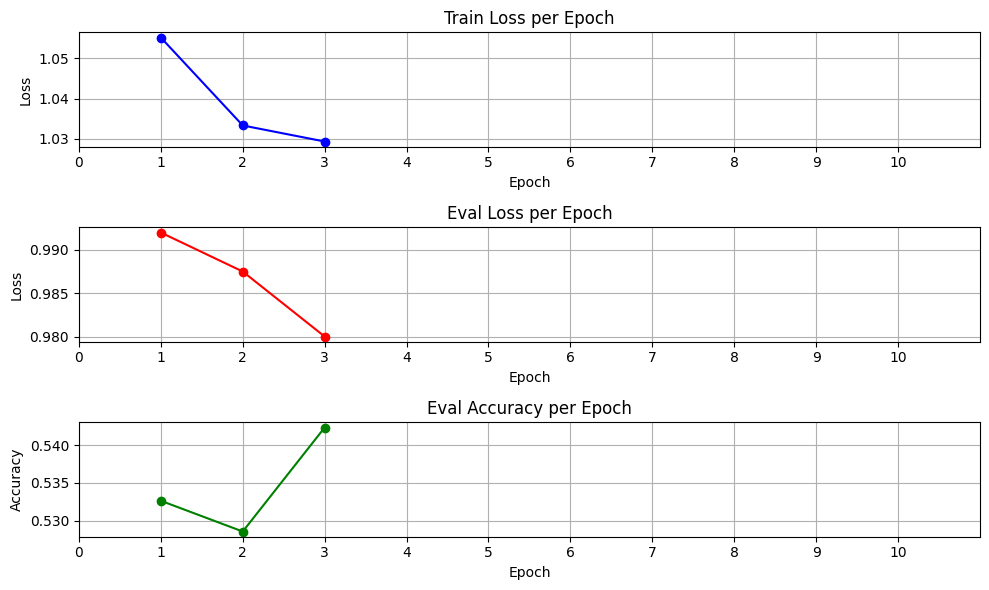

/root/.cache/pypoetry/virtualenvs/hp-otBRvMad-py3.10/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


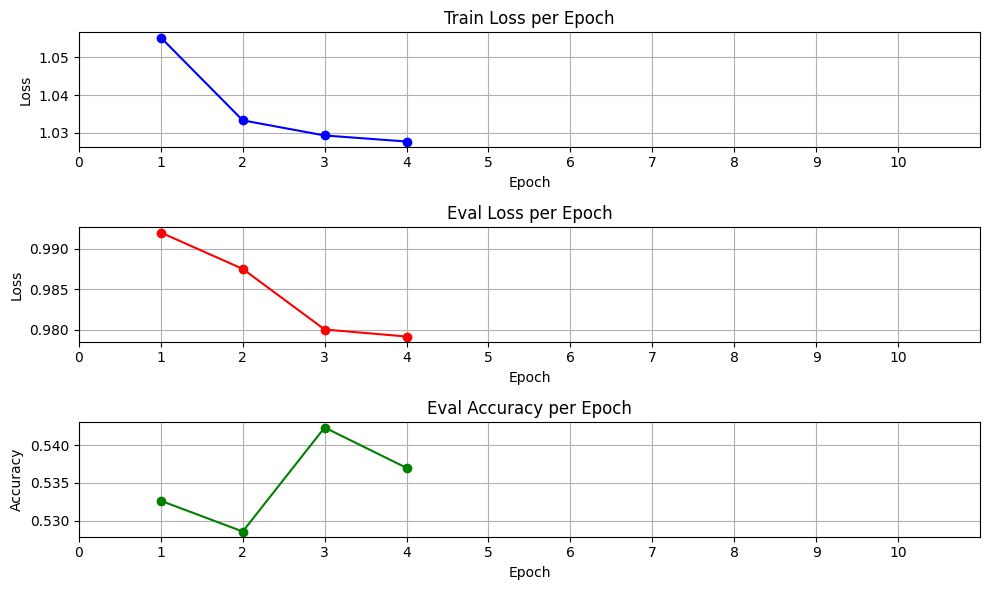

/root/.cache/pypoetry/virtualenvs/hp-otBRvMad-py3.10/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


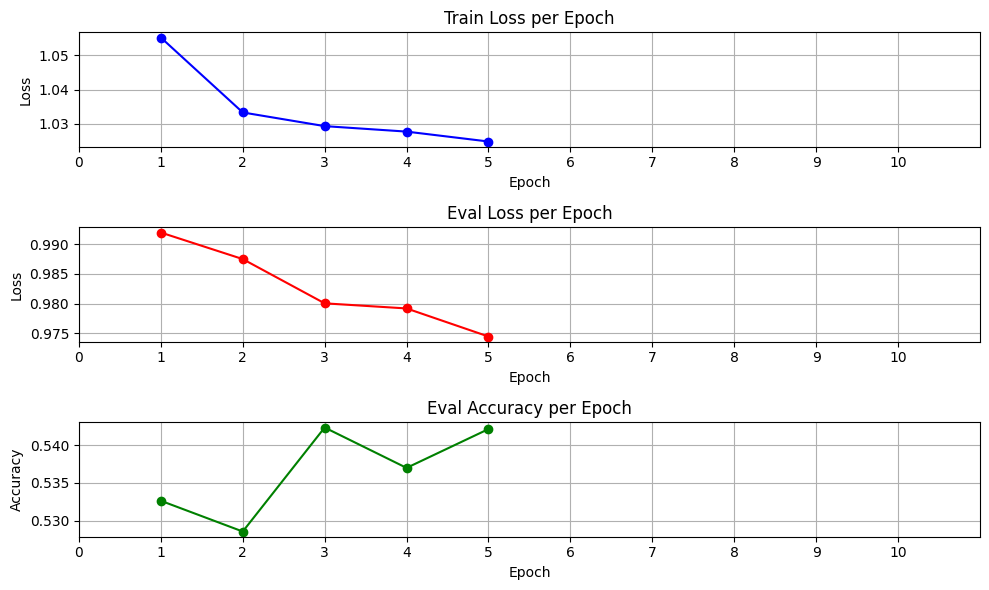

Best model was saved at: mnli_matched/checkpoint-4143
Best epoch: 3.0
Best eval_accuracy: 0.5423340378396272


TrainOutput(global_step=6905, training_loss=1.0340737576937002, metrics={'train_runtime': 964.2568, 'train_samples_per_second': 3665.32, 'train_steps_per_second': 14.322, 'total_flos': 1.2861025689466912e+17, 'train_loss': 1.0340737576937002, 'epoch': 5.0})

In [19]:
trainer.train()

In [20]:
trainer.evaluate(mnli_validation_matched)

/root/.cache/pypoetry/virtualenvs/hp-otBRvMad-py3.10/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.98366379737854,
 'eval_accuracy': 0.5376464595007642,
 'eval_runtime': 4.1338,
 'eval_samples_per_second': 2374.333,
 'eval_steps_per_second': 9.434,
 'epoch': 5.0}

In [21]:
trainer.evaluate(mnli_validation_mismatched)

/root/.cache/pypoetry/virtualenvs/hp-otBRvMad-py3.10/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.9694190621376038,
 'eval_accuracy': 0.5454637917005696,
 'eval_runtime': 4.0617,
 'eval_samples_per_second': 2420.686,
 'eval_steps_per_second': 9.602,
 'epoch': 5.0}

In [25]:
from transformers import AutoConfig

id2label = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech",
}
label2id = {
    "World": 0,
    "Sports": 1,
    "Business": 2,
    "Sci/Tech": 3,
}

config = AutoConfig.from_pretrained(
    "distilbert/distilbert-base-uncased",
    num_labels=4,
    hidden_dropout_prob=0.3,  # Dropout 확률 설정
    id2label=id2label,
    label2id=label2id,
)

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased",
    config=config,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [27]:
for param in model.distilbert.parameters():
    param.requires_grad = False

이러면 모델 구현은 완전히 마쳤습니다.
다음은 distilbert를 pre-train할 때 사용했던 tokenizer를 불러오고, 이 tokenizer를 가지고 이전과 똑같이 imdb dataset를 전처리합니다.


In [22]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")


def preprocess_function(data):
    return tokenizer(data["text"], truncation=True)


news_tokenized = news.map(preprocess_function, batched=True)
news_split = news_tokenized["train"].train_test_split(test_size=0.2)
news_train, news_val = news_split["train"], news_split["test"]
news_test = news_tokenized["test"]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

나머지는 기존의 학습과정과 완전히 동일합니다. `training_args`는 기존과 똑같이 활용할 때 distilbert를 fine-tuning하는 코드는 다음과 같습니다.


  0%|          | 0/1500 [00:00<?, ?it/s]

{'loss': 0.3175, 'grad_norm': 0.45771387219429016, 'learning_rate': 0.001, 'epoch': 1.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.28516894578933716, 'eval_accuracy': 0.89575, 'eval_runtime': 182.1957, 'eval_samples_per_second': 131.727, 'eval_steps_per_second': 1.032, 'epoch': 1.0}


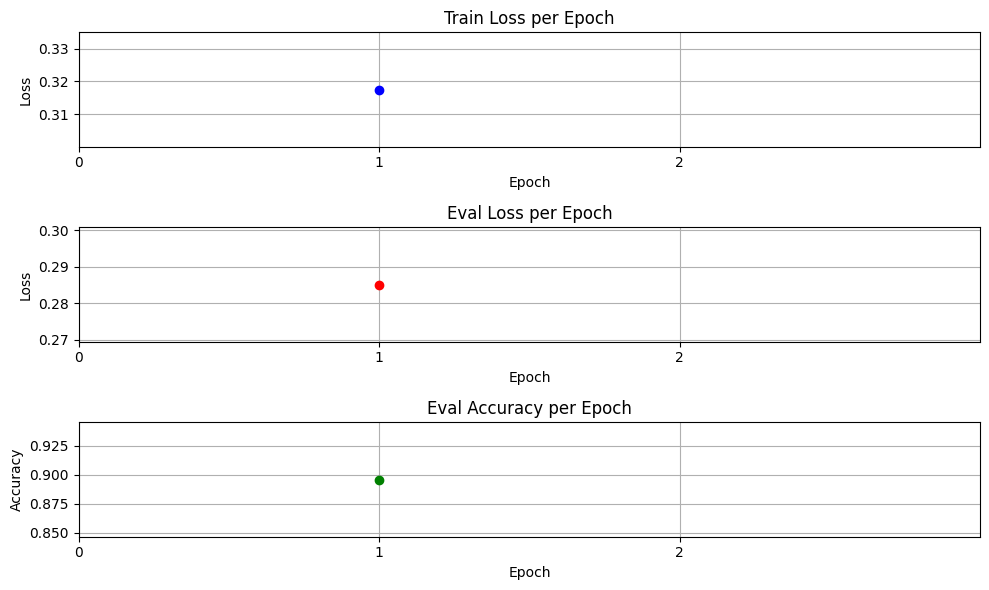

{'loss': 0.2759, 'grad_norm': 0.5386624932289124, 'learning_rate': 0.001, 'epoch': 2.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.2555958926677704, 'eval_accuracy': 0.90675, 'eval_runtime': 246.0154, 'eval_samples_per_second': 97.555, 'eval_steps_per_second': 0.764, 'epoch': 2.0}


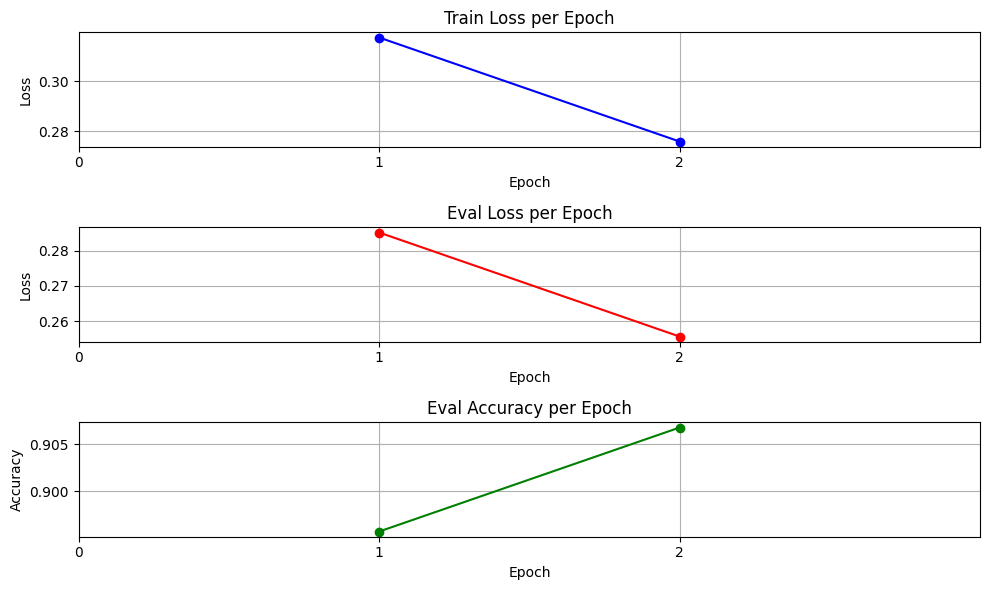

{'train_runtime': 1586.101, 'train_samples_per_second': 121.052, 'train_steps_per_second': 0.946, 'train_loss': 0.29671319580078126, 'epoch': 2.0}
Best model was saved at: news_classifier_01/checkpoint-1500
Best epoch: 2.0
Best eval_accuracy: 0.90675


TrainOutput(global_step=1500, training_loss=0.29671319580078126, metrics={'train_runtime': 1586.101, 'train_samples_per_second': 121.052, 'train_steps_per_second': 0.946, 'total_flos': 7927231217869824.0, 'train_loss': 0.29671319580078126, 'epoch': 2.0})

In [28]:
training_args = TrainingArguments(
    output_dir="news_classifier_01",  # 모델, log 등을 저장할 directory
    num_train_epochs=2,  # epoch 수
    per_device_train_batch_size=128,  # training data의 batch size
    per_device_eval_batch_size=128,  # validation data의 batch size
    logging_strategy="epoch",  # Epoch가 끝날 때마다 training loss 등을 log하라는 의미
    do_train=True,  # 학습을 진행하겠다는 의미
    do_eval=True,  # 학습 중간에 validation data에 대한 평가를 수행하겠다는 의미
    eval_strategy="epoch",  # 매 epoch가 끝날 때마다 validation data에 대한 평가를 수행한다는 의미
    save_strategy="epoch",  # 매 epoch가 끝날 때마다 모델을 저장하겠다는 의미
    learning_rate=1e-3,  # optimizer에 사용할 learning rate
    load_best_model_at_end=True,  # 학습이 끝난 후, validation data에 대한 성능이 가장 좋은 모델을 채택하겠다는 의미
    metric_for_best_model="eval_accuracy",  # best model을 accuracy 기준으로 선정
    greater_is_better=True,
    lr_scheduler_type="constant",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=news_train,
    eval_dataset=news_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[
        PlotCallback(),
        BestModelCallback(),
        EarlyStoppingCallback(early_stopping_patience=2),
    ],
)


trainer.train()
# trainer.save_model()

In [ ]:
import warnings

# 경고를 임시로 끄기
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    training_args.num_train_epochs = 10
    training_args.max_steps = 3000
    training_args.learning_rate = 8e-4
    trainer.train(resume_from_checkpoint="./hf_transformer_01/checkpoint-1500")
    # 이 블록 내에서만 경고가 무시됨

In [ ]:
import warnings

# 경고를 임시로 끄기
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    training_args.num_train_epochs = 10
    training_args.max_steps = 4500
    training_args.learning_rate = 6e-4
    trainer.train(resume_from_checkpoint="./hf_transformer_01/checkpoint-3000")
    # 이 블록 내에서만 경고가 무시됨

In [ ]:
import warnings

# 경고를 임시로 끄기
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    training_args.num_train_epochs = 10
    training_args.max_steps = 6000
    training_args.learning_rate = 4e-4
    trainer.train(resume_from_checkpoint="./hf_transformer_01/checkpoint-4500")
    # 이 블록 내에서만 경고가 무시됨

In [ ]:
import warnings

# 경고를 임시로 끄기
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    training_args.num_train_epochs = 10
    training_args.max_steps = 7500
    training_args.learning_rate = 2e-4
    trainer.train(resume_from_checkpoint="./hf_transformer_01/checkpoint-6000")
    # 이 블록 내에서만 경고가 무시됨

In [119]:
trainer.save_model()

학습한 모델에 대한 결과는 다음과 같습니다.


In [ ]:
trainer.predict(news_test)

In [ ]:
classifier = pipeline(
    "text-classification", model="./news_classifier_01/", device="mps"
)
print(
    classifier(
        "UK charges 8 in terror plot linked to alert in US LONDON, AUGUST 17: Britain charged eight terror suspects on Tuesday with conspiracy to commit murder and said one had plans that could be used in striking US buildings that were the focus of security scares this month."
    )
)